In [3]:
from pathlib import Path
import os
import pandas as pd

# Detecta raíz del proyecto aunque el notebook esté en "notebooks/"
BASE = Path().resolve()
if BASE.name.lower() == "notebooks":
    BASE = BASE.parent

DATA_DIR = BASE / "data"
RESULTS_DIR = BASE / "results"
CLEAN = DATA_DIR / "clean_superstore.csv"

# Asegura carpeta de resultados
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Carga (UTF-8 primero; si falla, latin1)
try:
    df = pd.read_csv(CLEAN, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(CLEAN, encoding="latin1")

print("Base dir:", BASE)
print("Loaded:", CLEAN, "→", df.shape)
df.head()

Base dir: C:\Proyectos\sales-data-cleaning
Loaded: C:\Proyectos\sales-data-cleaning\data\clean_superstore.csv → (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


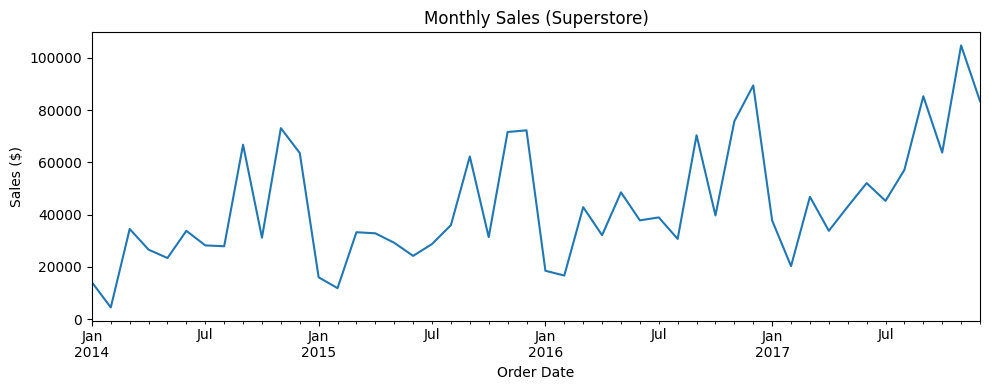

Train periods: 42 | Test periods: 6


(Order Date
 2017-02-01    20301.6314
 2017-03-01    46837.5620
 2017-04-01    33818.2215
 2017-05-01    43063.6494
 2017-06-01    52061.4463
 Freq: MS, Name: Sales, dtype: float64,
 Order Date
 2017-07-01     45265.7960
 2017-08-01     57128.6230
 2017-09-01     85279.8902
 2017-10-01     63740.5410
 2017-11-01    104707.5394
 Freq: MS, Name: Sales, dtype: float64)

In [4]:
import matplotlib.pyplot as plt

# Fechas
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df = df.dropna(subset=["Order Date"])

# Serie mensual: índice datetime con frecuencia mensual (inicio de mes = 'MS')
monthly_sales = (
    df.set_index("Order Date")["Sales"]
      .resample("MS").sum()
)

# Imputación suave si hay meses sin ventas (opcional)
monthly_sales = monthly_sales.fillna(0)

# Visual rápido
plt.figure(figsize=(10,4))
monthly_sales.plot(title="Monthly Sales (Superstore)")
plt.ylabel("Sales ($)")
plt.tight_layout()
plt.show()

# Split: últimos 6 meses como test
h = 6
train = monthly_sales.iloc[:-h]
test  = monthly_sales.iloc[-h:]

print(f"Train periods: {len(train)} | Test periods: {len(test)}")
train.tail(), test.head()

In [5]:
import warnings, itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

p = d = q = range(0, 3)      # 0,1,2
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_results = None

for order in pdq:
    try:
        model = SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_results = results
    except Exception:
        pass

print("Best (p,d,q):", best_order, "| AIC:", round(best_aic, 2))

Best (p,d,q): (0, 2, 2) | AIC: 857.2


MAE on test: 28,666.18


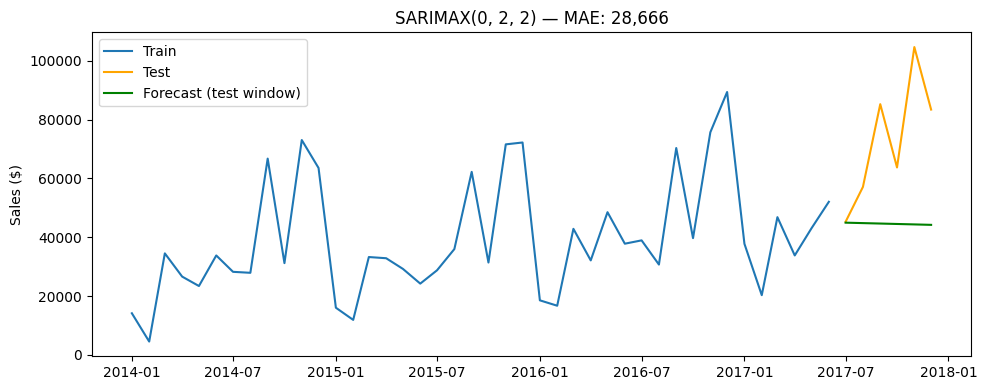

In [6]:
from sklearn.metrics import mean_absolute_error

# Predicción en el rango de test
forecast = best_results.predict(start=test.index[0], end=test.index[-1])

mae = mean_absolute_error(test, forecast)
print(f"MAE on test: {mae:,.2f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(forecast, label="Forecast (test window)", color="green")
plt.title(f"SARIMAX{best_order} — MAE: {mae:,.0f}")
plt.ylabel("Sales ($)")
plt.legend()
plt.tight_layout()
plt.show()

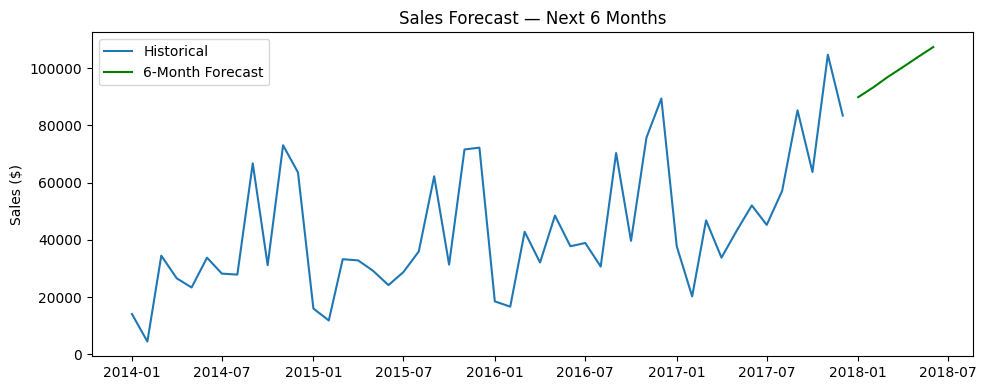

2018-01-01     89870.179505
2018-02-01     93371.025162
2018-03-01     96871.870819
2018-04-01    100372.716477
2018-05-01    103873.562134
2018-06-01    107374.407791
Freq: MS, dtype: float64

In [7]:
# Pronóstico n pasos a futuro desde el final de toda la serie
n_future = 6
# Refita en toda la serie para el forecast futuro
final_model = SARIMAX(monthly_sales, order=best_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
future_vals = final_model.forecast(steps=n_future)

# Índice futuro mensual (MS)
future_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(),
                             periods=n_future, freq="MS")
future_series = pd.Series(future_vals.values, index=future_index)

plt.figure(figsize=(10,4))
plt.plot(monthly_sales, label="Historical")
plt.plot(future_series, label=f"{n_future}-Month Forecast", color="green")
plt.title("Sales Forecast — Next 6 Months")
plt.ylabel("Sales ($)")
plt.legend()
plt.tight_layout()
plt.show()

future_series

In [8]:
# Guarda CSV con pronóstico
future_path = RESULTS_DIR / "sales_forecast_next6months.csv"
future_series.to_csv(future_path, header=["Forecast_Sales"], index_label="Month")
print("Saved forecast CSV →", future_path)

# Guarda resumen de evaluación y pronóstico
summary_path = RESULTS_DIR / "forecast_summary.txt"
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("Sales Forecast — Superstore (SARIMAX)\n")
    f.write("="*40 + "\n\n")
    f.write(f"Best order (p,d,q): {best_order}\n")
    f.write(f"MAE on test window: {mae:,.2f}\n\n")
    f.write("Next 6 months forecast:\n")
    for dt, val in future_series.items():
        f.write(f"- {dt.strftime('%Y-%m')}: ${val:,.2f}\n")
print("Saved summary →", summary_path)

Saved forecast CSV → C:\Proyectos\sales-data-cleaning\results\sales_forecast_next6months.csv
Saved summary → C:\Proyectos\sales-data-cleaning\results\forecast_summary.txt
